In [ ]:
# Setup
# Kaggle dataset link: https://www.kaggle.com/code/niharika41298/netflix-visualizations-recommendation-eda

# Common
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import datetime

# For ML
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/gdrive')

# Load Netflix data
file_path = "/content/gdrive/My Drive/Data Science/Projects/Netflix Movies and Shows/netflix_titles.csv"
netflix_overall = pd.read_csv(file_path)

# Load IMDB data for ratings and movies
imdb_ratings = pd.read_csv('/content/gdrive/My Drive/Data Science/Projects/Netflix Movies and Shows/IMDb ratings.csv',usecols=['weighted_average_vote'])
imdb_titles = pd.read_csv('/content/gdrive/My Drive/Data Science/Projects/Netflix Movies and Shows/IMDb movies.csv', usecols=['title','year','genre'])

Mounted at /content/gdrive


<ipython-input-1-3ca513dbdaf8>:34: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles = pd.read_csv('/content/gdrive/My Drive/Data Science/Projects/Netflix Movies and Shows/IMDb movies.csv', usecols=['title','year','genre'])


In [ ]:
# Looking at the general structure of the DataFrame
netflix_overall.head(5)

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [ ]:
# Shape of the DataFrame
df_shape = netflix_overall.shape
print(f"The raw DataFrame has {df_shape[0]} rows and {df_shape[1]} columns.")

The raw DataFrame has 8807 rows and 12 columns.


In [ ]:
netflix_overall.count()

show_id         8807
type            8807
title           8807
director        6173
cast            7982
country         7976
date_added      8797
release_year    8807
rating          8803
duration        8804
listed_in       8807
description     8807
dtype: int64

In [ ]:
netflix_overall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [ ]:
# Let's convert date_added from object Dtype to Date and Time
netflix_overall['date_added'] = pd.to_datetime(netflix_overall['date_added'])

In [ ]:
netflix_shows = netflix_overall[netflix_overall['type']=='TV Show']
netflix_movies = netflix_overall[netflix_overall['type']=='Movie']

#1 - Analysis of Movies vs. TV Shows

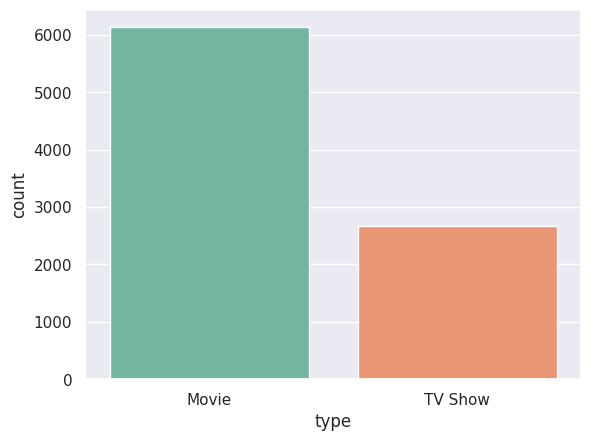

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=netflix_overall, palette="Set2")

Based on the plot, there are more movies on Netflix than TV shows.

#2 - Best time to release content?

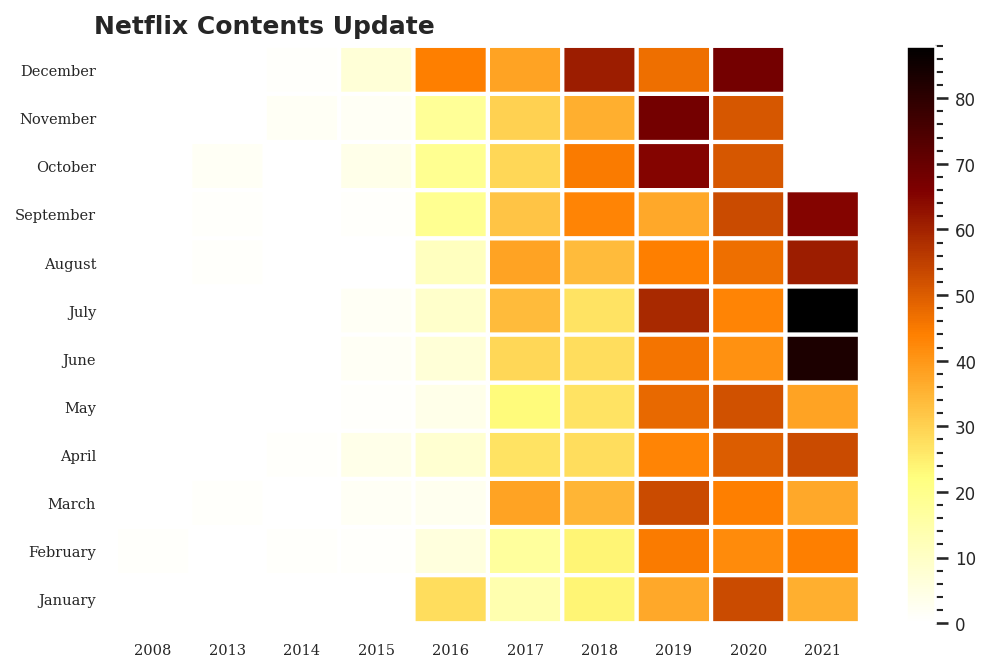

In [ ]:
# Let's look at the shows first, based on the date_added
# which month has the least amount of content added?
# Since we've determined that there were null values for the date_added column, let's remove those first.
netflix_date = netflix_shows[['date_added']].dropna()

# Added the year and month columns in the Dataframe
netflix_date['year'] = netflix_date['date_added'].dt.year
netflix_date['month'] = netflix_date['date_added'].dt.month_name()

# Sorting the month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Pivot the dataframe by year, month, and # of releases for each month & year
df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

# Heat map showing the high vs. low releases by month  and year
plt.figure(figsize=(8, 5), dpi=150)
plt.pcolor(df, cmap='afmhot_r', edgecolors='white', linewidths=2) # heatmap
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')

plt.title('Netflix Contents Update', fontsize=12, fontweight='bold', position=(0.20, 1.0+0.02))
cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=8)
cbar.ax.minorticks_on()
plt.show()

The 0s we see for 2021 - Oct, Nov, and Dec does not mean that there were no releases. Note that the data is valid up to September 2021.
- Based on the other years (i.e., 2016-2020), December, January, and February are the lighter months. However, this trend was not observed for year 2020. It is likely that external factors such as the COVID-19 Pandemic might have influenced the release dates, or some other external factors such as new collaborations that were not captured as part of this data set/analysis.

#3 - Movie Rating Analysis

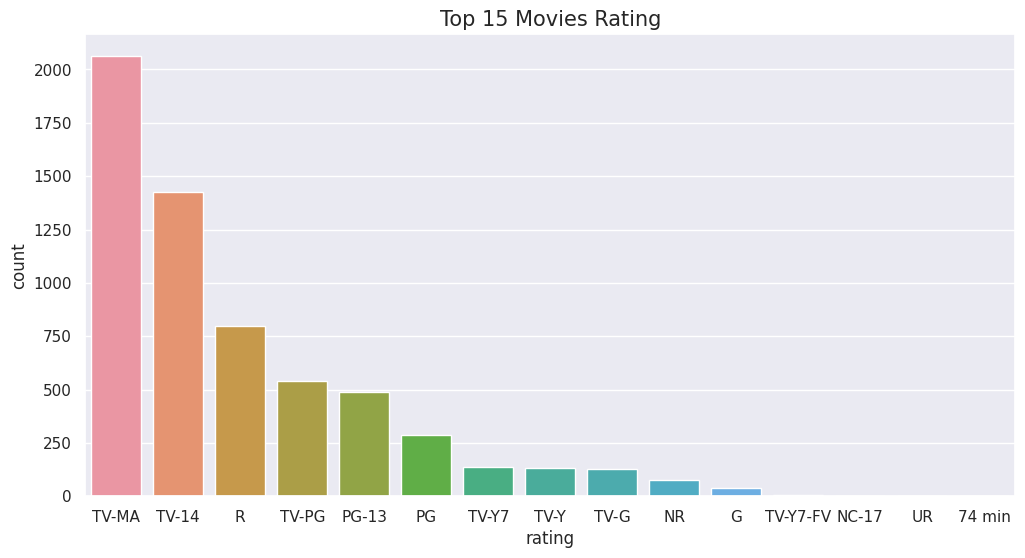

In [ ]:
# Starting with a simple Count plot, showing distribution
plt.figure(figsize=(12,6))
sns.set(style='darkgrid')

# Plotting out the top movies ratings
ax = sns.countplot(x='rating', data=netflix_movies, order=netflix_movies['rating'].value_counts().index[0:15])
plt.title("Top 15 Movies Rating", fontsize=15)
plt.show()

The distribution above makes sense as we look into the definition for each of these movie categories:
1. TV-MA: Mature Audience Only. Intended for aduits and may be unsuitable for children under 17.
2. TV-14: Parents Strongly Cautioned. Intended for children ages 14 and older in the company of an adult.
3. R: Restricted, designed to be viewed by adults, and therefore, maybe unsuitable for children under 17.

#4 - Analysing IMDB ratings to get top rated movies on Netflix

In [ ]:
# Since both sheets are in the same index order, we can just select the desired columns from each csv and merge as a DataFrame
ratings = pd.DataFrame({'Title':imdb_titles.title,
                    'Release Year':imdb_titles.year,
                    'Rating': imdb_ratings.weighted_average_vote,
                    'Genre':imdb_titles.genre})
ratings.drop_duplicates(subset=['Title','Release Year','Rating'], inplace=True)
ratings.shape

(85852, 4)

In [ ]:
# Checking for null values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85852 entries, 0 to 85854
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         85852 non-null  object 
 1   Release Year  85852 non-null  object 
 2   Rating        85852 non-null  float64
 3   Genre         85852 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.3+ MB


No null values based on the output above, so we don't need to handle them.

In [ ]:
# Let's compare the # of rows from each data-set prior to merge.
ratings_count = ratings.shape[0]
netflix_count = netflix_overall.shape[0]

print(f"# of entries for the ratings is {ratings_count} \n# of entries for the Netflix data is {netflix_count}")

# of entries for the ratings is 85852 
# of entries for the Netflix data is 8807


In [ ]:
# Performing an inner join on the IMDB Ratings and Netflix DataFrame. This will only show ratings if there's a record in the Netflix DataFrame
joint_data=ratings.merge(netflix_overall,left_on='Title',right_on='title',how='inner')
joint_data=joint_data.sort_values(by='Rating', ascending=False)

# How many entries do we have after joining the data?
print(f"# of entries after inner joining and merging is {joint_data.shape[0]}")

# of entries after inner joining and merging is 2960


In [ ]:
# Let's look at the top 10 movies on Netflix
top_rated = joint_data[:9]
fig = px.sunburst(top_rated,
                  path=['Title', 'country'],
                  values='Rating',
                  color='Rating',
                  hover_data=['description'],
                  title = "Top 10 Rated Movies on Netflix",
                  width=1000, height=600)
fig.show()

We can see that USA and India have the most number of movies in the top 10 rated movies on Netflix (based on IMBD Data Ratings data).

In [ ]:
# Identify Top 10 countries by the total # of movies and show their respective average rating

# First find the top 10 records and store in DataFrame format
country_count = joint_data['country'].value_counts().sort_values(ascending=False)
country_count = country_count[0:9]
country_count = pd.DataFrame({'country': country_count.index,
                             'count': country_count.values})

# Next groupby and calculate for the mean ratings for each country and store in DataFrame format
country_avg_rating = joint_data.groupby(['country'])['Rating'].mean().sort_values(ascending=False)
country_avg_rating = pd.DataFrame({'country': country_avg_rating.index,
                                  'avg_rating': country_avg_rating.values.round(2)})

# Joining the two DataFrames together
joint_country = country_count.merge(country_avg_rating, left_on='country', right_on='country', how='inner')
joint_country

country  count  avg_rating
0   United States    865        5.66
1           India    718        6.21
2  United Kingdom    119        5.65
3          Canada     57        5.39
4     Philippines     50        6.44
5           Spain     41        5.59
6       Indonesia     38        6.14
7     South Korea     38        6.17
8          France     37        6.09

#5 - Year-wise Analysis of Movies

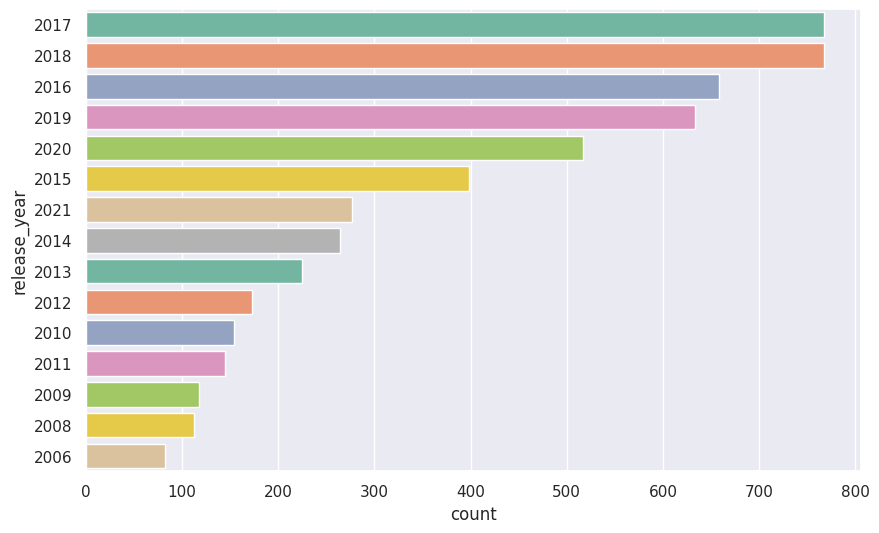

In [ ]:
# Let's do a count plot looking at the distribution of added movies by year
plt.figure(figsize=(10,6))
sns.set(style='darkgrid')

ax = sns.countplot(y="release_year", palette="Set2", data=netflix_movies, order=netflix_movies['release_year'].value_counts().index[:15])

Surprisingly, year 2017 and 2018 has more movies released compared to 2918 and 2020. The usual trend would be an increase each year. Additionally, we can see that 2016 also had more releases compared to 2015.

#6 - Top 10 Movie Content Creating Countries

In [ ]:
# Let's first create hashmap of # of countries and their counts
countries = {}

# Fill nas with Unknown
netflix_movies['country'] = netflix_movies['country'].fillna('Unknown')

# Creating a list of all countries, split by delimiter, and append to the hashmap if no key exist, otherwise, increment by 1.
country_list = list(netflix_movies['country'])
for i in country_list:
  i = list(i.split(','))

  # Handles non-multi countries
  if len(i) == 1:
    if i in list(countries.keys()):
      countries[i]+=1
    else:
      # This is to handle list as hashable so we can add to the dictionary as a key
      countries[i[0]]=1

  # Handles multi countries
  else:
    for j in i:
      if j in list(countries.keys()):
        countries[j]+=1
      else:
        # Since we are not indexing through a list, indexing by 0 is NOT required
        countries[j]=1

<ipython-input-18-f7a3063a85e5>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# However, based on the output, there are spaces which we have to move.. so let's fix that
countries_final = {}

for country,count in countries.items():
  country = country.replace(' ', '')
  if country in list(countries_final.keys()):
    countries_final[country]+=count
  else:
    countries_final[country]=count

# Sorting, and using the anonymous function to take values of the dictionary as key, which should result in a sorted diction from largest to smallest by values.
countries_final={k: v for k, v in sorted(countries_final.items(), key=lambda item: item[1], reverse= True)}

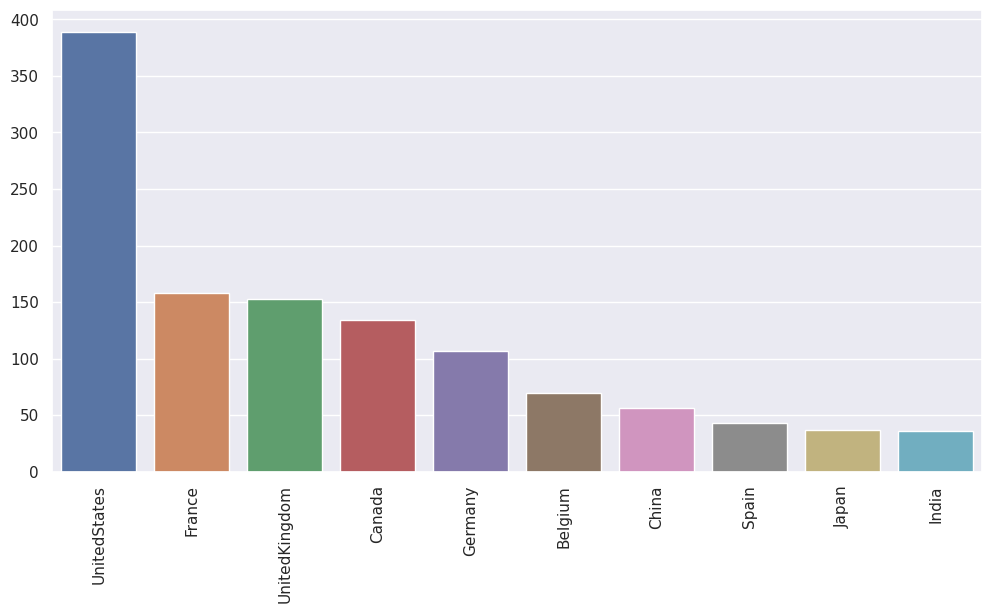

In [ ]:
# Plotting out the top 10 movie content creating countries
plt.figure(figsize=(12,6))
ax = sns.barplot(x=list(countries_final.keys())[0:10], y=list(countries_final.values())[0:10])

# Let's make the x axis labels more visible
ax.set_xticklabels(list(countries_final.keys())[0:10], rotation=90)
plt.show()

#7 - Let's look at the movie durations

In [ ]:
# A few things to note on the duration column: data type is object, and we will need to convert to int.
netflix_movies['duration'] = netflix_movies['duration'].str.replace(' min','')

# May need investigate why we can't use int for astype...
netflix_movies['duration'] = netflix_movies['duration'].astype(float)

<ipython-input-21-c9b5536eb94c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-21-c9b5536eb94c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



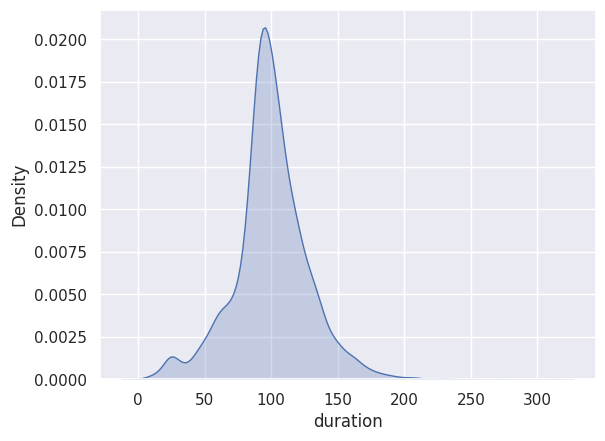

In [ ]:
sns.set(style="darkgrid")
sns.kdeplot(data=netflix_movies['duration'], fill=True)
plt.show()

Majority of the movies are between 90 to 110 minutes long (1.5hrs to almost 1hr and 50mins).

#8 - Let's take a look at the WordCloud for genres.

In [ ]:
# Counter function is used for tally
from collections import Counter

# The generated list can contain multiple genres... separated by a comma
genres=list(netflix_movies['listed_in'])
gen=[]


for i in genres:
    i=list(i.split(','))
    for j in i:
        # Prior to appending, remove the space
        gen.append(j.replace(' ',""))

# Using counter function to tally the number of occurrences of each genere. Should return a dict.
g=Counter(gen)

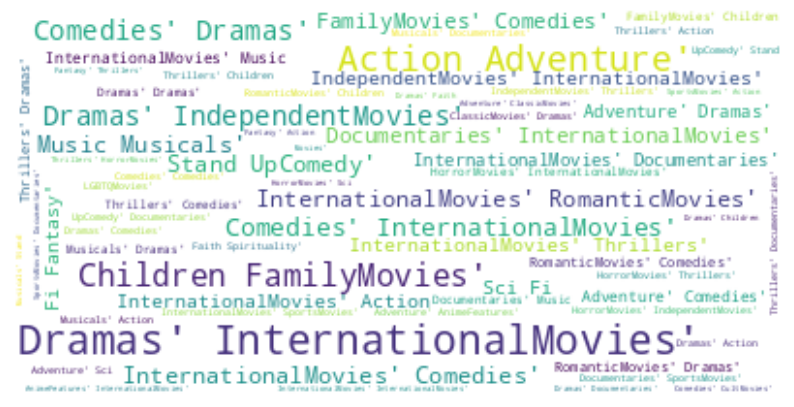

In [ ]:
# With the above dict completed for the WordCloud, let's now visualize it

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = list(gen)
plt.rcParams['figure.figsize'] = (10, 10)

#assigning shape to the word cloud

wordcloud = WordCloud(max_words=1000000,background_color="white").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

#9 - What about the top generes in a chart? rather than a wordcloud

<ipython-input-25-2b8296a387ff>:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



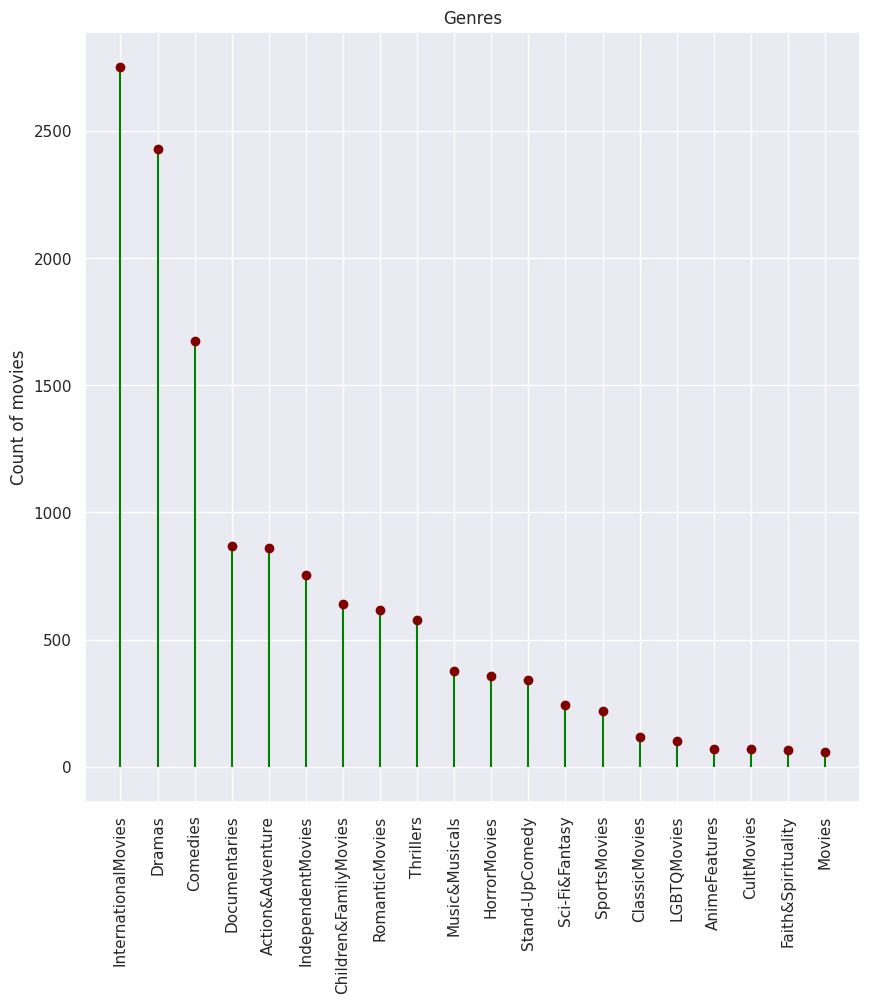

<Figure size 1000x1000 with 0 Axes>

In [ ]:
g={k: v for k, v in sorted(g.items(), key=lambda item: item[1], reverse= True)}


fig, ax = plt.subplots()

fig = plt.figure(figsize = (10, 10))
x=list(g.keys())
y=list(g.values())
ax.vlines(x, ymin=0, ymax=y, color='green')
ax.plot(x,y, "o", color='maroon')
ax.set_xticklabels(x, rotation = 90)
ax.set_ylabel("Count of movies")
# set a title
ax.set_title("Genres");

Based on the above, we can conclude that the top 3 movie generes (by count) are:
1. International Movies
2. Drama
3. Comedies

#10 - Let's now take a look at the TV Series on Netflix

In [ ]:
#Starting off by creating a country dictionary, showing each unique country, and their respective count
#Note that we've previously created seperate DataFrames for TV Shows and Movies

#Creating an empty dictionary to store countries and counts
countries_show = {}

#Handling the blank entries and storing in a list
netflix_shows['country'] = netflix_shows['country'].fillna('Unknown')
countries_show_list = list(netflix_shows['country'])

#Iterating through the list and appending to the dictionary as applicable
for i in countries_show_list:
  i = list(i.split(','))

  #This loop handles single entries
  if len(i)==1:
    if i in list(countries_show.keys()):
      countries_show[i]+=1
    else:
      countries_show[i[0]]=1

  #This loop handles multiple entries
  else:
    for j in i:
      if j in list(countries_show.keys()):
        countries_show[j]+=1
      else:
        countries_show[j]=1

<ipython-input-26-437c7841fc87>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Now the next step would be to remove the blanks
countries_final_list = {}

#Iterate through the dictionary and remove spaces
for country, num in countries_show.items():
  country = country.replace(" ", "")
  if country in countries_final_list:
    countries_final_list[country]+= num
  else:
    countries_final_list[country] = num

countries_final_list = {k:v for k, v in sorted(countries_final_list.items(), key=lambda item:item[1], reverse=True)}

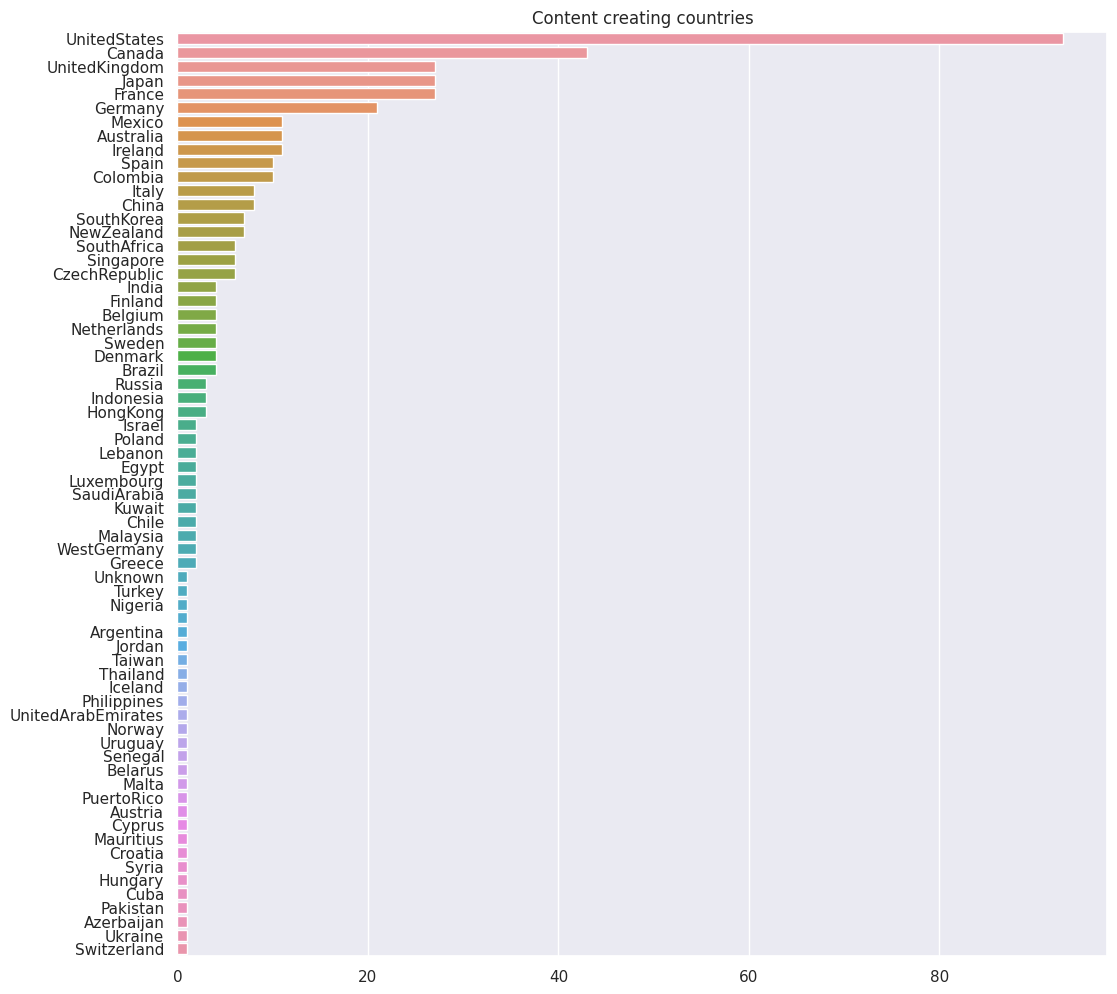

In [ ]:
plt.figure(figsize=(12,12))

plt.title("Content creating countries")

sns.barplot(y=list(countries_final_list.keys()), x=list(countries_final_list.values()))

plt.show()

# 11 - Let's take a look at which TV shows have the longest # of seasons.

In [ ]:
netflix_shows.head()

show_id     type                  title         director  \
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   
5      s6  TV Show          Midnight Mass    Mike Flanagan   

                                                cast       country date_added  \
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...  South Africa 2021-09-24   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...       Unknown 2021-09-24   
3                                                NaN       Unknown 2021-09-24   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...         India 2021-09-24   
5  Kate Siegel, Zach Gilford, Hamish Linklater, H...       Unknown 2021-09-24   

   release_year rating   duration  \
1          2021  TV-MA  2 Seasons   
2          2021  TV-MA   1 Season   
3          2021  TV-MA   1 Season   
4          2021  TV-MA  2 Seasons   
5          2021  TV-MA   1 Season   

                                           listed_in  \
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   
5                 TV Dramas, TV Horror, TV Mysteries   

                                         description  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...  
5  The arrival of a charismatic young priest brin...

In [ ]:
features = ['title', 'duration']
durations = netflix_shows[features]

durations["no_seasons"] = durations['duration'].str.replace(" Season", "").str.replace("s", "")
durations["no_seasons"] = durations['no_seasons'].astype(int)

<ipython-input-30-4077d7f0fde8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-4077d7f0fde8>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Let's visualize which TV show has the highest # of seasons

# First, create a dummy df to store top 20
top = durations[['title', 'no_seasons']]
top = top.sort_values(by='no_seasons', ascending=False)

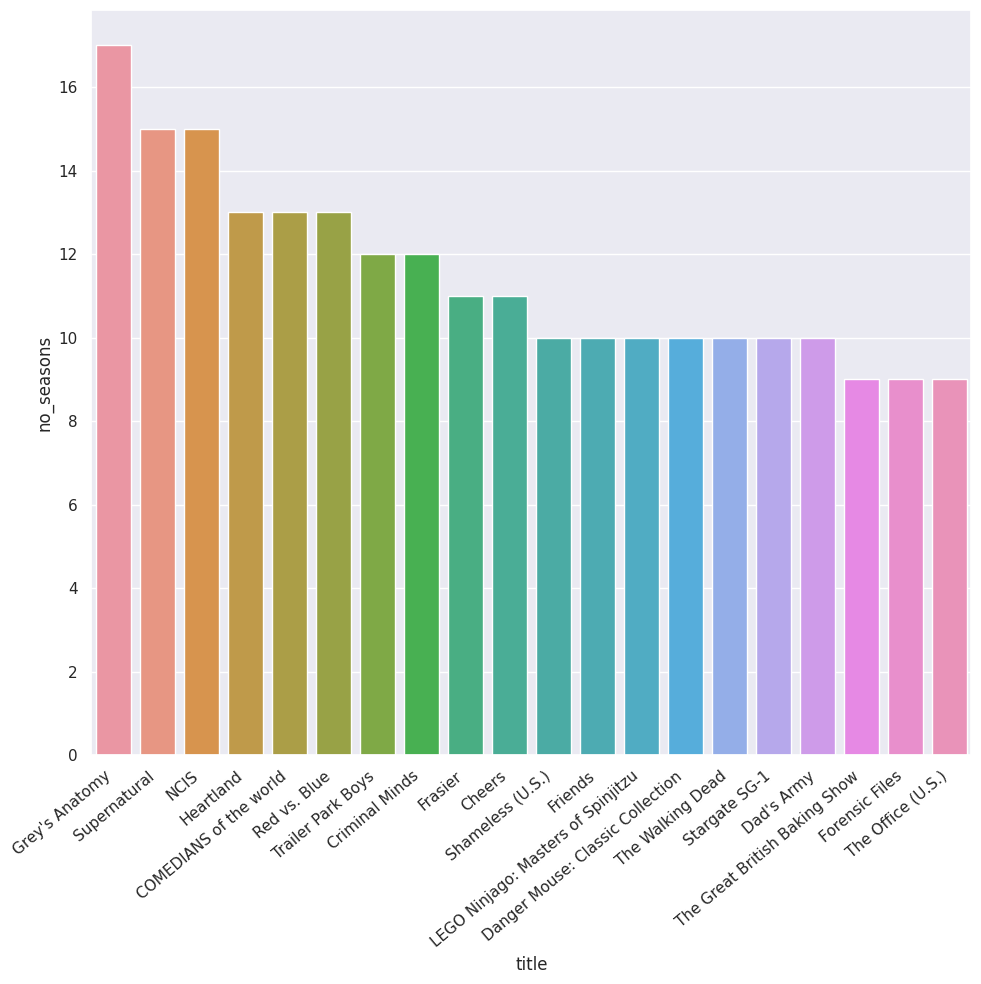

In [ ]:
# Now let's plot out the top 20 results
top_20 = top[:20]
ax = sns.barplot(data=top_20, x='title', y='no_seasons')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Based on the barplot, we can see that Grey's Anatomy tops out at 17 episodes, followed by Supernatural and NCIS, both at 15 episodes.

In [ ]:
# What about the lowest number of seasons?
bottom = top.sort_values(by='no_seasons')
bottom_20 = bottom[:20]

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['Title', 'Number of Seasons']),
                 cells=dict(values=[bottom_20['title'],bottom_20['no_seasons']],fill_color='lavender'))
                     ])
fig.show()

# 12 - Let's take a look at the WordCloud for generes, but for TV Shows this time

In [ ]:
shows_genere_list = list(netflix_shows['listed_in'])
shows_genere = []
for i in shows_genere_list:
  i = list(i.split(","))
  for j in i:
    shows_genere.append(j.replace(" ", ""))

g = Counter(shows_genere)

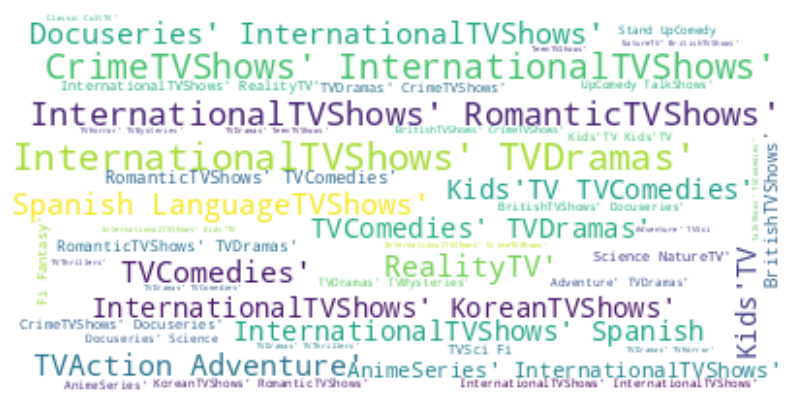

In [ ]:
# With the above dict completed for the WordCloud, let's now visualize it

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = list(shows_genere)
plt.rcParams['figure.figsize'] = (10, 10)

#assigning shape to the word cloud

wordcloud = WordCloud(max_words=1000000,background_color="white").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

# 13 - Oldest Movies released in the U.S. that's on Netflix?

In [ ]:
# Filtering for records that have United States as the Country of Origin, and bottom 20.
us_shows = netflix_shows[netflix_shows['country'] == 'United States']
us_shows_old_20 = us_shows.sort_values(by='release_year').head(20)
us_shows_new_20 = us_shows.sort_values(by='release_year').tail(20)

In [ ]:
# Plotting out the oldest 20 shows on Netflix
fig =go.Figure(data=[go.Table(header=dict(values=['Title', 'Released Year']),
cells=dict(values=[us_shows_old_20['title'],us_shows_old_20['release_year']],fill_color='lavender'))
])
fig.show()

In [ ]:
# Plotting out newest 20 shows on Netflix (note that the dataset is only up the year 2021)
fig =go.Figure(data=[go.Table(header=dict(values=['Title', 'Released Year']),
cells=dict(values=[us_shows_new_20['title'],us_shows_new_20['release_year']],fill_color='lavender'))
])
fig.show()

# 14 - Recommendation System

TF-IDF stands for term frequency-inverse document frequency and it is a measure, used in the fields of information retrieval (IR) and machine learning, that can quantify the importance or relevance of string representations (words, phrases, lemmas, etc)  in a document amongst a collection of documents (also known as a corpus).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
netflix_overall['description'] = netflix_overall['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(netflix_overall['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8807, 18895)

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim =linear_kernel(tfidf_matrix,tfidf_matrix)

# Define indices, and getting rid of duplicates
indices = pd.Series(netflix_overall.index, index=netflix_overall['title']).drop_duplicates()

In [ ]:
def get_recommendations(title,cosine_sim=cosine_sim):
  idx = indices[title]

  # Get the pairwise similarity scores of all movies with that movie
  sim_scores = list(enumerate(cosine_sim[idx]))

  # Sort the movies based on the similarity scores
  sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)

  # Get the scores of the 10 most similar movies
  sim_scores = sim_scores[1:11]

  # Get the movie indices
  movie_indices = [i[0] for i in sim_scores]

  # Return the top 10 most similar movies
  return netflix_overall['title'].iloc[movie_indices]

In [ ]:
get_recommendations("Kuroko's Basketball")

27                                Grown Ups
8754                                 Wolves
3314    100 Things to do Before High School
6510                           Coach Carter
3276                       My MVP Valentine
2105                                  Hoops
5381                   Degrassi: Next Class
7494               Monster High: Fright On!
1443                 QB1: Beyond the Lights
2029           The Babysitter: Killer Queen
Name: title, dtype: object

In [ ]:
get_recommendations('Peaky Blinders')

7683                    Our Godfather
2646                   My Stupid Boss
3133                              Don
8293                         The Fear
7140    Jonathan Strange & Mr Norrell
7785                Power Rangers Zeo
8467                       The Prison
8539                       The Tudors
1510                    The Con Is On
8391     The Legend of Michael Mishra
Name: title, dtype: object

The model looks okay, but we can also see that it isn't very accurate. Let's try to improve the model further.

# 15 - Content based filtering on multiple metrics

Content based filtering on the following factors:

1. Title
2. Cast
3. Director
4. Listed in
5. Description

In [ ]:
# First, fill null values with empty string
na_filtered = netflix_overall.fillna("")

# Second, defining a function to make everything to lowercase, and getting rid of spaces
def lower_case(title):
  return str.lower(title.replace(" ", ""))

# Third, identifying which features to be filtered
filter_features = ['title', 'cast', 'director', 'listed_in', 'description']

In [ ]:
# Now let's apply those filterings
na_filtered = na_filtered[filter_features]

In [ ]:
# Calling the lowercase function
for feature in filter_features:
  na_filtered[feature] = na_filtered[feature].apply(lower_case)

In [ ]:
na_filtered.head()

title                                               cast  \
0    dickjohnsonisdead                                                      
1          blood&water  amaqamata,khosingema,gailmabalane,thabangmolab...   
2            ganglands  samibouajila,tracygotoas,samueljouy,nabihaakka...   
3  jailbirdsneworleans                                                      
4          kotafactory  mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...   

         director                                          listed_in  \
0  kirstenjohnson                                      documentaries   
1                          internationaltvshows,tvdramas,tvmysteries   
2  julienleclercq  crimetvshows,internationaltvshows,tvaction&adv...   
3                                               docuseries,realitytv   
4                    internationaltvshows,romantictvshows,tvcomedies   

                                         description  
0  asherfathernearstheendofhislife,filmmakerkirst...  
1  aftercrossingpathsataparty,acapetownteensetsou...  
2  toprotecthisfamilyfromapowerfuldruglord,skille...  
3  feuds,flirtationsandtoilettalkgodownamongthein...  
4  inacityofcoachingcentersknowntotrainindia’sfin...

In [ ]:
# Now let's create a new column: soup or bag of words for all columns for each row
# Define the function
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

In [ ]:
# Apply the function to create a new bag column with all the descriptions
na_filtered['soup'] = na_filtered.apply(create_soup, axis=1)

In [ ]:
# Now let's use a CountVectorizer instead of a the tfid model
# CountVectorizer simply counts the number of times a word appears in a document (using a bag-of-words approach),
# while TF-IDF Vectorizer takes into account not only how many times a word appears in a document but also
# how important that word is to the whole corpus.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(na_filtered['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Resetting the index for na_filtered
na_filtered=na_filtered.reset_index()
indices = pd.Series(na_filtered.index, index=na_filtered['title'])

In [ ]:
# Now let's define the new get_recommendations news function
def get_recommendations_new(title, cosine_sim=cosine_sim):
  # Removing the blanks
  title=title.replace(' ','').lower()
  idx = indices[title]

  # Get the pairwise similarity scores of all movies with that movie
  sim_scores = list(enumerate(cosine_sim[idx]))

  # Sort the movies based on the similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # Get the scores of the 10 most similar movies
  sim_scores = sim_scores[1:11]

  # Get the movie indices
  movie_indices = [i[0] for i in sim_scores]

  # Return the top 10 most similar movies
  return netflix_overall['title'].iloc[movie_indices]

In [ ]:
# Let's test out the recommendation model
get_recommendations_new('Breaking Bad', cosine_sim2)

2931                       Better Call Saul
678     The Assassination of Gianni Versace
1980                          The Blacklist
2767                                  Ozark
1477                                Dare Me
3762                    Designated Survivor
8397           The Lizzie Borden Chronicles
4079                               Unsolved
3684                              Kakegurui
3604                               Sintonia
Name: title, dtype: object

In [ ]:
# Continue to test recommendation
get_recommendations_new('Peaky Blinders', cosine_sim2)

3034                    Giri / Haji
5032    The Frankenstein Chronicles
8431          The Murder Detectives
4951                         Loaded
4809                  Kiss Me First
6922                   Happy Valley
2184                       Get Even
519                   I AM A KILLER
3789                 Killer Ratings
4476          Terrorism Close Calls
Name: title, dtype: object

If desired we can also download a database with book titles and identify if there's any matching titles between movies, tv shows, and books.